In [54]:
import pandas as pd
import numpy as np
import random
import operator
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram

In [55]:
# Read the dataset
file_path = 'RWB_02112023195802159.csv'
data = pd.read_csv(file_path)

# Filter the dataset for 'Disposable income per capita' and 'Life expectancy at birth'
income_life_exp_data = data[data['Indicator'].isin(['Disposable income per capita', 'Life expectancy at birth'])]

# Pivot the data to have one row per region with both indicators
pivot_data = income_life_exp_data.pivot_table(index=['REG_ID', 'Regions', 'TIME', 'Time'], 
                                              columns='Indicator', 
                                              values='Value').reset_index()

# Normalize the features
scaler = MinMaxScaler()
features_to_cluster = pivot_data[['Disposable income per capita', 'Life expectancy at birth']]
normalized_features = scaler.fit_transform(features_to_cluster)
normalized_df = pd.DataFrame(normalized_features, columns=features_to_cluster.columns)


In [56]:
def cluster_distance_centroid_link(c1, c2):
    return math.sqrt((c2[1]-c1[1])**2+(c2[0]-c1[0])**2)

def find_min_clusters(clusters):
    curr_cluster_1 = 0
    curr_cluster_2 = 1
    curr_dist = -1
    for i in range(0, len(clusters)):
        for y in range(i+1, len(clusters)):
            new_dist = cluster_distance_centroid_link(clusters[i], clusters[y])
            if curr_dist < 0 or curr_dist > cluster_distance_centroid_link(clusters[i], clusters[y]):
                curr_cluster_1 = i
                curr_cluster_2 = y
                curr_dist = cluster_distance_centroid_link(clusters[i], clusters[y])
    return curr_cluster_1, curr_cluster_2, curr_dist

In [57]:
def hierarchical_clustering_linkage(df):
    # linkage used for dendrogram drawing
    linkage = []
    
    # List of current elements, in their x and y dimensions, zipped together
    curr_x = [x for x in df.iloc[:,0]]
    curr_y = [y for y in df.iloc[:,1]]
    curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
    
    # Indices of current clusters
    idxs = [i for i in normalized_df.index]
    
    # The number of items in each cluster
    items_per_cluster = [1 for i in range(0, len(curr_x))]

    while len(curr_clusters) > 1:
        # Get cluster indices and distances
        c1, c2, curr_dist = find_min_clusters(curr_clusters)
        
        # Specify new cluster centroids
        new_c = []
        new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
        new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)
        
        # Remove old clusters from the set of current clusters
        curr_clusters.pop(c1)
        curr_clusters.pop(c2-1)
        
        # Increment for new cluster
        idxs.append(idxs[-1] + 1)
        
        # Add new cluster to list of clusters
        curr_clusters.append(new_c)
        
        # Update number of items per cluster, removing old ones and adding in new one
        num_items = items_per_cluster[c1] + items_per_cluster[c2]
        items_per_cluster.pop(c1)
        items_per_cluster.pop(c2-1)
        items_per_cluster.append(num_items)
        
        # Add new iteraion to linkage
        linkage.append([idxs[c1], idxs[c2], curr_dist, num_items])
        
        # Remove old cluster indices
        idxs.pop(c1)
        idxs.pop(c2-1)
    
    return linkage

In [58]:
linkage = hierarchical_clustering_linkage(normalized_df)
pd.DataFrame(linkage, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(len(linkage))])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,167,168,0.000000,2
cluster 2,169,390,0.000000,3
cluster 3,212,213,0.000000,2
cluster 4,124,289,0.000033,2
cluster 5,223,224,0.000250,2
...,...,...,...,...
cluster 385,35,770,0.351924,59
cluster 386,772,773,0.367345,329
cluster 387,16,775,0.540456,330
cluster 388,346,776,0.582397,331


In [59]:
len(linkage)

389

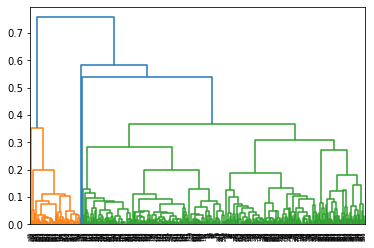

In [195]:
original_indices = [i for i in normalized_df.index]
row_dendr = dendrogram(linkage, labels=original_indices)

In [275]:
def initialize_membership_matrix(n, k):
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for _ in range(k)]
        summation = sum(random_num_list)
        temp_list = [x / summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

# Update membership values based on the cluster centers
def update_membership_values(membership_mat, cluster_centers, df, m, k):
    p = float(2 / (m - 1))
    for i in range(len(df)):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(distances[j] / distances[c], p) for c in range(k) if distances[c] != 0])
            membership_mat[i][j] = float(1 / den) if den != 0 else 0
    return membership_mat

# Calculate the centers of clusters using the membership matrix
def calculate_cluster_centers(membership_mat, df, m, k):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        x_raised = [e ** m for e in x]
        denominator = sum(x_raised)
        temp_num = []
        for i in range(len(df)):
            data_point = list(df.iloc[i])
            prod = [x_raised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z / denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [276]:
curr_x = [x for x in normalized_df.iloc[:100,0]]
curr_y = [y for y in normalized_df.iloc[:100,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [i for i in normalized_df.index[:100]]
items_per_cluster = [1 for i in range(0, len(curr_x))]
n = len(normalized_df[:100])
k = len(curr_clusters)
k

100

In [406]:
# def find_min_fuzzy_clusters(clusters):
df_cpy = normalized_df[:100].copy(deep=True)
fuzzy_linkage = []
curr_x = [x for x in df_cpy.iloc[:,0]]
curr_y = [y for y in df_cpy.iloc[:,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [i for i in df_cpy.index]
items_per_cluster = [1 for i in range(0, len(curr_x))]
m = 2.00
n = len(df_cpy)
k = len(curr_clusters)
mat = initialize_membership_matrix(n, k)

while len(curr_clusters) > 1:
    n = len(df_cpy)
    k = len(curr_clusters)
    
    mat = initialize_membership_matrix(n, k)
    mat = update_membership_values(mat, curr_clusters, df_cpy, m, k)
    new_clusters = np.argwhere(mat == np.amax(mat))[0]
    c1 = new_clusters[0]
    c2 = new_clusters[1]
    curr_dist = np.amax(mat)
    new_dist = math.sqrt((curr_clusters[c1][0] - curr_clusters[c2][0])**2 + (curr_clusters[c1][1] - curr_clusters[c2][1])**2)
    print(f"c1 {c1} c2 {c2} curr dist {-math.log(new_dist)}")
#     print(f"idxs {idxs}")

    # Specify new cluster centroids
    new_c = []
    new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
    new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)

    # Remove old clusters from the set of current clusters
    curr_clusters.pop(c1)
    curr_clusters.pop(c2-1)

    # Drop old elements in dataframe
    df_cpy = df_cpy.drop([c1, c2])
    df_cpy = df_cpy.reset_index(drop=True)
    
    # Add in new cluster to dataframe
    df_cpy.loc[len(df_cpy)] = new_c
    
    # Increment for new cluster
    idxs.append(idxs[-1] + 1)

    # Add new cluster to list of clusters
    curr_clusters.append(new_c)

    # Update number of items per cluster, removing old ones and adding in new one
    num_items = items_per_cluster[c1] + items_per_cluster[c2]
    items_per_cluster.pop(c1)
    items_per_cluster.pop(c2-1)
    items_per_cluster.append(num_items)

    # Add new iteraion to linkage
    fuzzy_linkage.append([idxs[c1], idxs[c2], -math.log(new_dist), num_items])
    
    # Remove old cluster indices
    if c2 > c1:
        idxs.pop(c1)
        idxs.pop(c2-1)
    else:
        idxs.pop(c2)
        idxs.pop(c1-1)

c1 23 c2 74 curr dist 8.293249319931224
c1 57 c2 56 curr dist 7.069473888309115
c1 97 c2 55 curr dist 7.76262106886906
c1 96 c2 54 curr dist 8.455768249428973
c1 95 c2 53 curr dist 9.148915429988918
c1 94 c2 52 curr dist 9.842062610548732
c1 93 c2 51 curr dist 10.535209791108677
c1 92 c2 50 curr dist 11.228356971668623
c1 91 c2 49 curr dist 11.921504152229613
c1 90 c2 48 curr dist 12.614651332789558
c1 89 c2 47 curr dist 13.30779851335368
c1 88 c2 46 curr dist 14.000945693913625
c1 87 c2 45 curr dist 14.69409287447357
c1 86 c2 44 curr dist 15.387240055033516
c1 85 c2 43 curr dist 16.08038723559346
c1 84 c2 42 curr dist 16.77353441628705
c1 83 c2 41 curr dist 17.466681596846993
c1 82 c2 40 curr dist 18.15982877740694
c1 81 c2 39 curr dist 18.852975957966883
c1 80 c2 38 curr dist 19.546123136388555
c1 79 c2 37 curr dist 20.2392703169485
c1 78 c2 36 curr dist 20.932417497508446
c1 77 c2 35 curr dist 21.62556467806839
c1 76 c2 34 curr dist 22.318711892840746
c1 75 c2 33 curr dist 23.011859

In [407]:
flpd = pd.DataFrame(fuzzy_linkage, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(len(fuzzy_linkage))])
flpd

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,23,74,8.293249,2
cluster 2,58,57,7.069474,2
cluster 3,101,56,7.762621,3
cluster 4,102,55,8.455768,4
cluster 5,103,54,9.148915,5
...,...,...,...,...
cluster 95,193,97,37.429948,48
cluster 96,194,98,37.429948,49
cluster 97,195,99,37.429948,50
cluster 98,196,100,37.429948,51


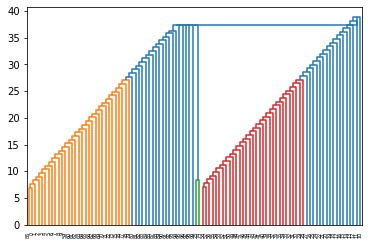

In [410]:
fuzzy_indices = [i for i in normalized_df[:100].index]
row_dendr = dendrogram(fuzzy_linkage, labels=fuzzy_indices)